<a href="https://colab.research.google.com/github/tobyloby12/AMLS-assignment/blob/main/Task%20B/transfer_learning_Task_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/amlsAssignment')

In [ ]:
import pandas as pd
import os

# Sorting the dataset into the directoryies with different class names for loading in the data in batches using keras image_dataset_from_directory function

In [ ]:
# put correct path to AMLSassignment github folder
path = '/content/drive/MyDrive/amlsAssignment'

In [ ]:
# sorting data into class directories
# creating directories and sorting images based on dataframe image labels
from tqdm.auto import tqdm
from shutil import copy2

os.chdir(path + '/dataset')
df = pd.read_csv('label.csv')
try:
  os.mkdir('class_dataset')
except:
  print('Directory already created')
os.chdir(path + '/dataset/class_dataset')
classes = []
for row in tqdm(df.iterrows()):
  image_name = row[1][0]
  label = row[1][1]
  if label not in classes:
    classes.append(label)
    try:
      os.mkdir(f'{label}')
    except:
      print('Directory already created')
  
  copy2(path + f'/dataset/image/{image_name}', path + f'/dataset/class_dataset/{label}')

In [ ]:
# doing the same for the test dataset
# sorting data into class directories

os.chdir(path + '/dataset')
df = pd.read_csv('./test/label.csv')
try:
  os.mkdir('class_dataset_test')
except:
  print('Directory already created')
os.chdir(path + '/dataset/class_dataset_test')
classes = []
for row in tqdm(df.iterrows()):
  image_name = row[1][0]
  label = row[1][1]
  if label not in classes:
    classes.append(label)
    try:
      os.mkdir(f'{label}')
    except:
      print('Directory already created')
  
  copy2(path + f'/dataset/test/image/{image_name}', path + f'/dataset/class_dataset_test/{label}')

Directory already created


0it [00:00, ?it/s]

Directory already created


In [ ]:
# using the image_dataset_from_directory function to create the datasets for training of neural networks from the directory created above

from tensorflow.keras.preprocessing import image_dataset_from_directory
os.chdir(path)
train_dataset = image_dataset_from_directory(
    os.getcwd() + '/dataset/class_dataset',
    validation_split=0.3,
    subset='training',
    seed=0,
    image_size=(256, 256),
    batch_size=32

)

validate_dataset = image_dataset_from_directory(
    os.getcwd() + '/dataset/class_dataset',
    validation_split=0.3,
    subset='validation',
    seed=0,
    image_size=(256, 256),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    os.getcwd() + '/dataset/class_dataset_test',
    seed=0,
    image_size=(256, 256),
    batch_size=32
)

Found 3000 files belonging to 4 classes.
Using 2100 files for training.
Found 3000 files belonging to 4 classes.
Using 900 files for validation.
Found 200 files belonging to 4 classes.


# Trying out VGG16 model to assess its performance

In [ ]:
# importing VGG16 without head
from keras.applications.vgg16 import VGG16

model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

In [ ]:
# making entire model trainable
for layer in model.layers:
  layer.trainable = True

In [ ]:
# adding additional layers to classify
from keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import models


# model = Model(inputs=model.inputs, outputs=output)


model = models.Sequential([
    model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
# compiling model with loss function and optimiser along with callbacks to save the most important model and early stopping to avoid unnecesary training
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# can change model save location
mc = ModelCheckpoint('best_model_VGG16_3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


model.compile(optimizer=Adam(learning_rate=0.00004), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# trianing the model and saving data to history
history = model.fit(train_dataset, validation_data=validate_dataset, epochs = 40, callbacks=[es, mc])

Epoch 1/40
66/66 [==============================] - ETA: 0s - loss: 1.3209 - accuracy: 0.6429
Epoch 00001: val_accuracy improved from -inf to 0.75444, saving model to best_model_VGG16_3.h5
66/66 [==============================] - 522s 7s/step - loss: 1.3209 - accuracy: 0.6429 - val_loss: 0.6437 - val_accuracy: 0.7544
Epoch 2/40
66/66 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.8633
Epoch 00002: val_accuracy improved from 0.75444 to 0.86667, saving model to best_model_VGG16_3.h5
66/66 [==============================] - 26s 393ms/step - loss: 0.3937 - accuracy: 0.8633 - val_loss: 0.3860 - val_accuracy: 0.8667
Epoch 3/40
66/66 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.9348
Epoch 00003: val_accuracy did not improve from 0.86667
66/66 [==============================] - 22s 323ms/step - loss: 0.1858 - accuracy: 0.9348 - val_loss: 0.4856 - val_accuracy: 0.8411
Epoch 4/40
66/66 [==============================] - ETA: 0s - loss: 0.1198 -

In [ ]:
# loading saved model
model.load_weights('best_model_VGG16_3.h5')

In [ ]:
# finding all predictions using numpy and appending so that f1 score ect can be evalutated
import numpy as np
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])

  labels = np.concatenate([labels, y])

In [ ]:
# creating direcdtory to put figures in
try:
  os.mkdir(path + '/figures')
except:
  print('Directory exists')

Directory exists


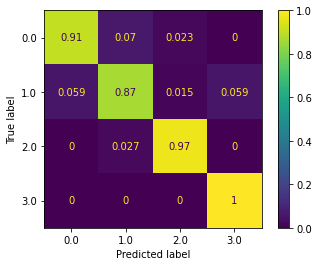

In [ ]:
# showing confusion matrix of model to assess performance
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix = ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='true')

confusion_matrix.figure_.savefig(os.getcwd() + '/figures/confusion_matrix_VGG16_2.png')

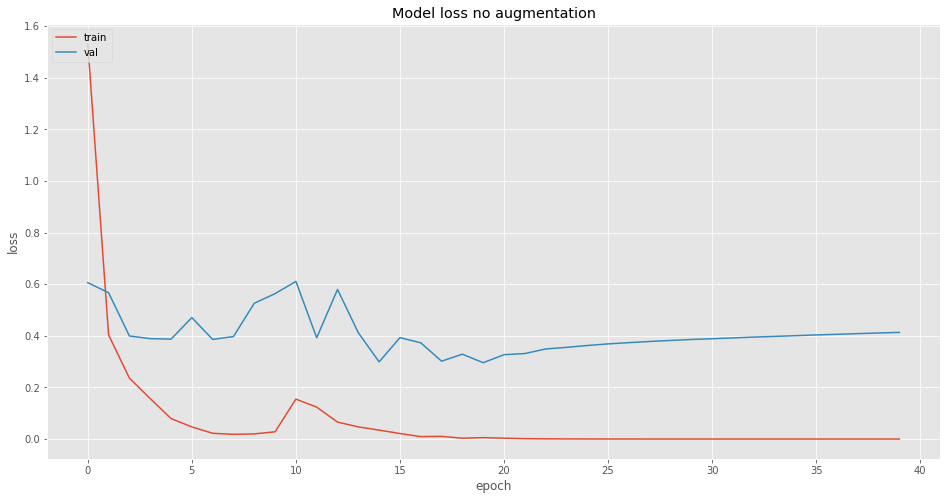

In [ ]:
# plotting loss
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss no augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( os.getcwd() + '/figures/loss_VGG16_3.png')
plt.show()

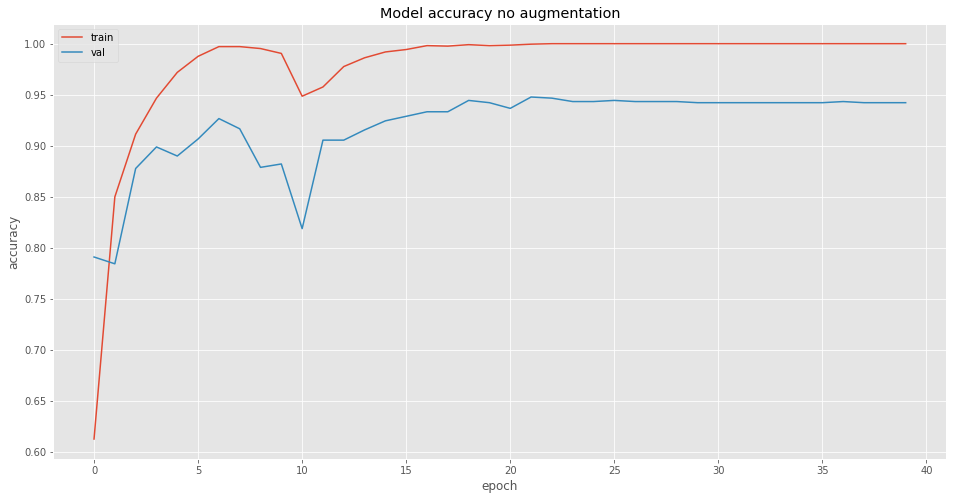

In [ ]:
# plotting accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy no augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( './figures/accuracy_VGG16_3.png')
plt.show()

In [ ]:
# showing accuracy
from sklearn.metrics import accuracy_score

accuracy_score(labels, predictions)

0.935

# Xception

In [ ]:
# importing xception model without head
import tensorflow as tf
xception_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None
)


In [ ]:
# making all layers trainable
for layer in model.layers:
  layer.trainable = True

In [ ]:
# adding additional layers to model for classification
from keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import models




model = models.Sequential([
    xception_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
# compiling model with loss function and optimiser along with callbacks to save the most important model and early stopping to avoid unnecesary training

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model_Xception_1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.00004), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# training model
history = model.fit(train_dataset, validation_data=validate_dataset, epochs = 40, callbacks=[es, mc])

Epoch 1/40
66/66 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.7571
Epoch 00001: val_accuracy improved from -inf to 0.76889, saving model to best_model_Xception_1.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


66/66 [==============================] - 54s 739ms/step - loss: 0.6767 - accuracy: 0.7571 - val_loss: 0.6543 - val_accuracy: 0.7689
Epoch 2/40
66/66 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9629
Epoch 00002: val_accuracy improved from 0.76889 to 0.80000, saving model to best_model_Xception_1.h5
66/66 [==============================] - 56s 836ms/step - loss: 0.1096 - accuracy: 0.9629 - val_loss: 0.9030 - val_accuracy: 0.8000
Epoch 3/40
66/66 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9919
Epoch 00003: val_accuracy improved from 0.80000 to 0.88222, saving model to best_model_Xception_1.h5
66/66 [==============================] - 54s 804ms/step - loss: 0.0314 - accuracy: 0.9919 - val_loss: 0.5711 - val_accuracy: 0.8822
Epoch 4/40
66/66 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9986
Epoch 00004: val_accuracy improved from 0.88222 to 0.90778, saving model to best_model_Xception_1.h5
66/66 [============

In [ ]:
# loading best model for evaluation
model.load_weights('best_model_Xception_1')

In [ ]:
# creating predictions
import numpy as np
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])

  labels = np.concatenate([labels, y])

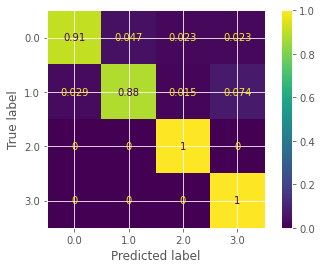

In [ ]:
# plotting confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix = ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='true')

confusion_matrix.figure_.savefig(os.getcwd() + '/figures/confusion_matrix_xception_2.png')

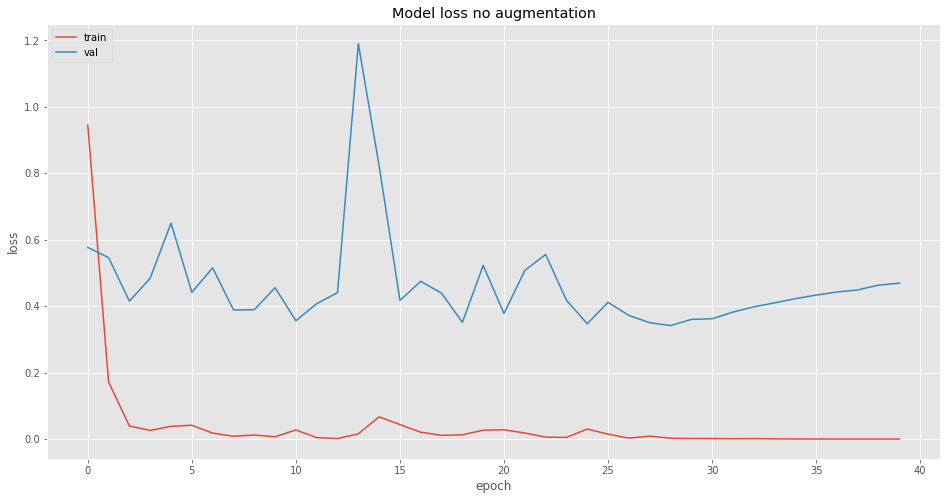

In [ ]:
# plotting loss function
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss no augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( os.getcwd() + '/figures/loss_xception_2.png')
plt.show()

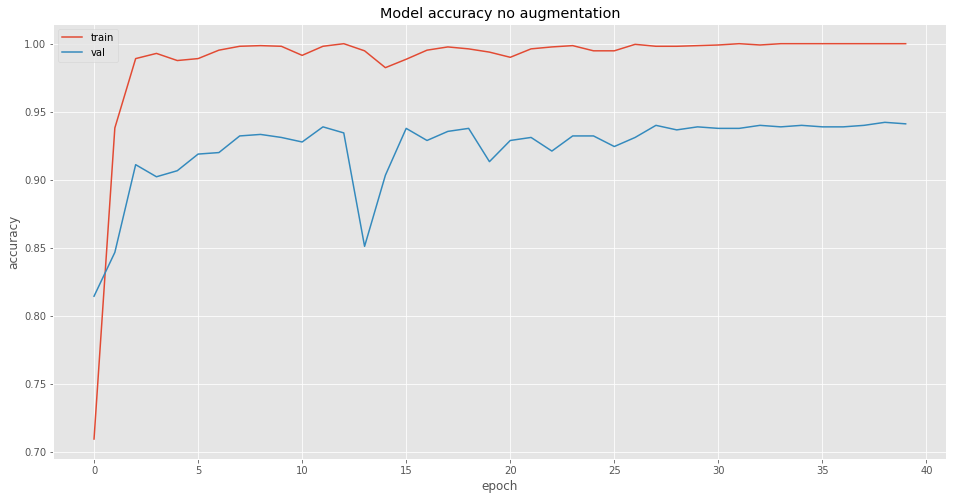

In [ ]:
# plotting accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy no augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( './figures/accuracy_xception_2.png')
plt.show()

In [ ]:
# showing accuracy on test dataset
from sklearn.metrics import accuracy_score

accuracy_score(labels, predictions)

0.94

# Efficient Net

In [ ]:
# importing efficientNetB4 without head
import tensorflow as tf
efficient_model = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=True,
    classes=1000,
    classifier_activation="softmax"
)


71696384/71686520 [==============================] - 1s 0us/step


In [ ]:
# adding layers for classification
from keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import models


# model = Model(inputs=model.inputs, outputs=output)


model = models.Sequential([
    efficient_model,
    Flatten(),
    Dense(10, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
# compiling model with loss function and optimiser along with callbacks to save the most important model and early stopping to avoid unnecesary training

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model_efficient_5.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.00004, beta_1=0.99), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# training model
history = model.fit(train_dataset, validation_data=validate_dataset, epochs = 50, callbacks=[es, mc])

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.7451 - accuracy: 0.6957
Epoch 00001: val_accuracy improved from -inf to 0.67333, saving model to best_model_efficient_5.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


66/66 [==============================] - 268s 3s/step - loss: 0.7451 - accuracy: 0.6957 - val_loss: 0.8464 - val_accuracy: 0.6733
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.9014
Epoch 00002: val_accuracy improved from 0.67333 to 0.76667, saving model to best_model_efficient_5.h5
66/66 [==============================] - 50s 755ms/step - loss: 0.2710 - accuracy: 0.9014 - val_loss: 0.6011 - val_accuracy: 0.7667
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9514
Epoch 00003: val_accuracy did not improve from 0.76667
66/66 [==============================] - 47s 700ms/step - loss: 0.1355 - accuracy: 0.9514 - val_loss: 0.7228 - val_accuracy: 0.7433
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9752
Epoch 00004: val_accuracy did not improve from 0.76667
66/66 [==============================] - 47s 700ms/step - loss: 0.0742 - accuracy: 0.9752 - val_loss: 0.8977 - v

In [ ]:
# loading best model weights
model.load_weights('best_model_efficient_4.h5')

In [ ]:
# getting all predictions
import numpy as np
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])

  labels = np.concatenate([labels, y])

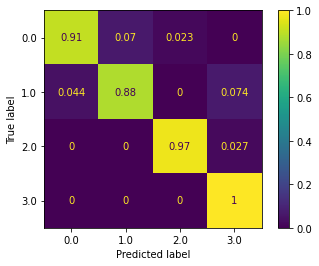

In [ ]:
# plotting confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix = ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='true')

confusion_matrix.figure_.savefig(os.getcwd() + '/figures/confusion_matrix_efficientNetB45.png')

In [ ]:
# plotting loss graph
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss no augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( os.getcwd() + '/figures/loss_efficientNetB44.png')
plt.show()

In [ ]:
# plotting accuracy graph
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy no augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( './figures/accuracy_efficientNetB44.png')
plt.show()

In [ ]:
# showing accuracy
from sklearn.metrics import accuracy_score

accuracy_score(labels, predictions)

0.935